# I. Setting Up

In [1]:
# import relevant packages
import numpy as np
import scipy. stats as sts
import matplotlib.pyplot as plt
import pandas as pd
import pystan
import datetime as dt
import seaborn
%matplotlib inline


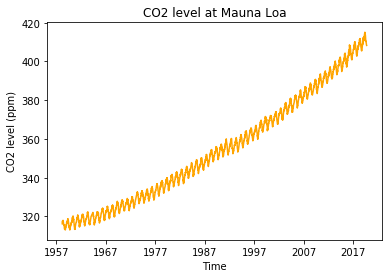

Size of dataset:  3139


In [2]:
# Load the data
dataset = pd.read_csv('weekly_in_situ_co2_mlo.csv')
# Convert time to date format
dataset['Time'] = pd.to_datetime(dataset['Time'])
# Plot the data
plt.plot(dataset['Time'], dataset['CO2'], color='orange')
plt.title('CO2 level at Mauna Loa')
plt.xlabel('Time')
plt.ylabel('CO2 level (ppm)')
plt.show()
size = len(dataset.iloc[:, 1])
print('Size of dataset: ', size)

In [3]:
# Create a new column to store time differences
dataset['t'] = [0 for i in range(len(dataset.iloc[:, 1]))]
for i in range(len(dataset.iloc[:, 0])):
    dataset.iloc[i, 2] = (dataset.iloc[i, 0] - dataset.iloc[0, 0]).days
# Split the dataset to train and test
train = dataset.iloc[:2100, :]
test = dataset.iloc[2100: , :]

In [4]:
# Take a look at the dataset
dataset.tail()

,Time,CO2,t
3134,2019-08-31,409.32,22435
3135,2019-09-07,408.80,22442
3136,2019-09-14,408.61,22449
3137,2019-09-21,408.50,22456
3138,2019-09-28,408.28,22463


In [51]:
# Create a dataframe for time in the future
future = pd.DataFrame()
future['Time'] = pd.date_range(start='2019-10-05', end='2058-01-07', freq = 'W')
future['t'] = [0 for i in range(len(future['Time']))]
for i in range(len(future['t'])):
    future.iloc[i, 1] = (future.iloc[i, 0] - dataset.iloc[0, 0]).days

In [6]:
total_time = dataset['t'].append(future['t'])
total_time_date = dataset['Time'].append(future['Time'])
# Take a look at future time
future.tail()

,Time,t
1992,2057-12-09,36415
1993,2057-12-16,36422
1994,2057-12-23,36429
1995,2057-12-30,36436
1996,2058-01-06,36443


# II. Stan Models
## 1. Construct the models

In [7]:
# Stan data
stan_data = {
    # Train, test, future time and data
    'cd_data': train.iloc[:, 1],
    'time': train.iloc[:, 2],
    'N': len(train.iloc[:, 1]),
    'M': len(test.iloc[:, 1]),
    'test_time': test.iloc[:, 2],
    'future_time': future['t'],
    'L': len(future['t']),
    'T': len(dataset['t']) + len(future['t']),
    'total_time': total_time
}

In [8]:
stan_code1 = """

data {
    int<lower=0> N;
    real<lower=0> cd_data[N];
    int<lower=0> time[N];
    int<lower=0> M;
    int<lower=0> test_time[M];
    int<lower=0> L;
    int<lower=0> future_time[L];
    int<lower=0> T;
    int<lower=0> total_time[T];
}

parameters {
    real<lower=0> c;
    real<lower=0> c0;
    real<lower=0> c1;
    real<lower=0> A;
    real<lower=0, upper=pi()> phi;
    real<lower=0> sigma;

}

model {
    c ~ cauchy(0, 1);
    c0 ~ cauchy(0, 1);
    A ~ cauchy(0, 1);
    phi ~ cauchy(0, 1);
    sigma ~ normal(0, 1);
    for (i in 1:N) {
        cd_data[i] ~ normal(c + c0*time[i] + A*cos(2*pi()*time[i] / 365.25 + phi), sigma);
    }
}
    
generated quantities {
    real cd_test[M];
    real cd_future[L];
    real trend[T];
    
    for(j in 1:M) {
        cd_test[j] = normal_rng(c + c0*test_time[j] + A*cos(2*pi()*test_time[j] / 365.25 + phi), sigma);
    }
    
    
    for (k in 1:L) {
        cd_future[k] = normal_rng(c + c0*future_time[k] + A*cos(2*pi()*future_time[k] / 365.25 + phi), sigma);
    }
    
    
    for (q in 1:T) {
        trend[q] = normal_rng(c + c0*total_time[q], sigma);
    }
    
}

"""

In [9]:
stan_code2 = """

data {
    int<lower=0> N;
    real<lower=0> cd_data[N];
    int<lower=0> time[N];
    int<lower=0> M;
    int<lower=0> test_time[M];
    int<lower=0> L;
    int<lower=0> future_time[L];
    int<lower=0> T;
    int<lower=0> total_time[T];
}

parameters {
    real<lower=0> c;
    real<lower=0> c0;
    real<lower=0> c1;
    real<lower=0> A;
    real<lower=0, upper=2*pi()> phi;
    real<lower=0> sigma;

}

model {
    c ~ cauchy(0, 1);
    c0 ~ cauchy(0, 1);
    c1 ~ cauchy(0, 1);
    A ~ normal(2, 1);
    phi ~ uniform(0, 2*pi());
    sigma ~ normal(0, 0.25);
    for (i in 1:N) {
        cd_data[i] ~ normal(c + c0*time[i] + c1*time[i]^2 + A*cos(2*pi()*time[i] / 365.25 + phi), sigma);
    }
}
    
generated quantities {
    real cd_test[M];
    real cd_future[L];
    real trend[T];
    
    for(j in 1:M) {
        cd_test[j] = normal_rng(c + c0*test_time[j] + c1*test_time[j]^2 + A*cos(2*pi()*test_time[j] / 365.25 + phi), sigma);
    }
    
    
    for (k in 1:L) {
        cd_future[k] = normal_rng(c + c0*future_time[k] + c1*future_time[k]^2 + A*cos(2*pi()*future_time[k] / 365.25 + phi), sigma);
    }
    
    
    for (q in 1:T) {
        trend[q] = normal_rng(c + c0*total_time[q] + c1*total_time[q]^2, sigma);
    }
    
}

"""

In [10]:
stan_code3 = """

data {
    int<lower=0> N;
    real<lower=0> cd_data[N];
    int<lower=0> time[N];
    int<lower=0> M;
    int<lower=0> test_time[M];
    int<lower=0> L;
    int<lower=0> future_time[L];
    int<lower=0> T;
    int<lower=0> total_time[T];
}

parameters {
    real c;
    real c0;
    real<lower=0> c1;
    real<lower=0> A;
    real<lower=0, upper=pi()> phi;
    real<lower=0> sigma;

}

model {
    c ~ normal(0, 0.5);
    c0 ~ normal(0, 0.25);
    c1 ~ normal(0, 1);
    A ~ normal(0, 1);
    phi ~ normal(0, 1);
    sigma ~ normal(0, 0.25);
    for (i in 1:N) {
        cd_data[i] ~ normal(c + c0*time[i] + c1*time[i]^2 + A*cos(2*pi()*time[i] / 365.25 + phi), sigma);
    }
}
    
generated quantities {
    real cd_test[M];
    real cd_future[L];
    real trend[T];
    
    for(j in 1:M) {
        cd_test[j] = normal_rng(c + c0*test_time[j] + c1*test_time[j]^2 + A*cos(2*pi()*test_time[j] / 365.25 + phi), sigma);
    }
    
    
    for (k in 1:L) {
        cd_future[k] = normal_rng(c + c0*future_time[k] + c1*future_time[k]^2 + A*cos(2*pi()*future_time[k] / 365.25 + phi), sigma);
    }
    
    
    for (q in 1:T) {
        trend[q] = normal_rng(c + c0*total_time[q] + c1*total_time[q]^2, sigma);
    }
    
}

"""

In [11]:
stan_code4 = """

data {
    // train, test, future time and data
    int<lower=0> N;
    real<lower=0> cd_data[N];
    int<lower=0> time[N];
    int<lower=0> M;
    int<lower=0> test_time[M];
    int<lower=0> L;
    int<lower=0> future_time[L];
    int<lower=0> T;
    int<lower=0> total_time[T];
}

parameters {
    // unknown quantities
    // coefficients for quadratic trend
    real<lower=0> c;
    real<lower=0> c0;
    real<lower=0> c1;
    // amplitude and phase for seasonal changes
    real<lower=0> A;
    real<lower=0, upper=pi()> phi;
    // standard deviation for noise
    real<lower=0> sigma;

}

model {
    // priors for the parameters
    c ~ cauchy(0, 1);
    c0 ~ cauchy(0, 1);
    c1 ~ cauchy(0, 1);
    A ~ normal(2, 1);
    phi ~ uniform(0, pi());
    sigma ~ normal(0, 0.25);
    // likelihood function
    for (i in 1:N) {
        cd_data[i] ~ normal(c + c0*time[i] + c1*time[i]^2 + A*cos(2*pi()*time[i] / 365.25 + phi), sigma);
    }
}
    
generated quantities {
    // generated data
    real cd_test[M];
    real cd_future[L];
    real trend[T];
    
    // replicate test data
    for(j in 1:M) {
        cd_test[j] = normal_rng(c + c0*test_time[j] + c1*test_time[j]^2 + A*cos(2*pi()*test_time[j] / 365.25 + phi), sigma);
    }
    
    // generate future data
    for (k in 1:L) {
        cd_future[k] = normal_rng(c + c0*future_time[k] + c1*future_time[k]^2 + A*cos(2*pi()*future_time[k] / 365.25 + phi), sigma);
    }
    
    // generate the quadratic trend
    for (q in 1:T) {
        trend[q] = normal_rng(c + c0*total_time[q] + c1*total_time[q]^2, sigma);
    }
    
}

"""

## 2. Run The Models

In [12]:
# Compile the model
stan_model1 = pystan.StanModel(model_code=stan_code1)
stan_model2 = pystan.StanModel(model_code=stan_code2)
stan_model3 = pystan.StanModel(model_code=stan_code3)
stan_model4 = pystan.StanModel(model_code=stan_code4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b9a5ac600848c7188fe63710dec54dac NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d5528f4956cd6f78c79322f12e3a3750 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0ea129f1af6fecaa097637a2248e0a30 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d5e238ee890d6e492bbe5c7675ac229 NOW.


In [13]:
# Get the posteriors for the parameters
parameters_mod1 = ['c', 'c0', 'A', 'phi', 'sigma']
parameters = ['c', 'c0', 'c1', 'A', 'phi', 'sigma']
results1 = stan_model1.sampling(data=stan_data)
results2 = stan_model2.sampling(data=stan_data)
results3 = stan_model3.sampling(data=stan_data)
results4 = stan_model4.sampling(data=stan_data)
print('Model 1', results1.stansummary(pars=parameters_mod1))
print('Model 2', results2.stansummary(pars=parameters))
print('Model 3', results3.stansummary(pars=parameters))
print('Model 4', results4.stansummary(pars=parameters))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Model 1 Inference for Stan model: anon_model_b9a5ac600848c7188fe63710dec54dac.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c     310.56    0.01   0.09  310.4  310.5 310.55 310.61 310.73     58   1.05
c0    3.6e-3  8.4e-7 9.1e-6 3.6e-3 3.6e-3 3.6e-3 3.6e-3 3.6e-3    118   1.04
A       2.59    0.01   0.05   2.47   2.55   2.59   2.61    2.7     27    1.1
phi   1.6e-3  2.5e-4 5.6e-4 6.6e-4 1.1e-3 1.5e-3 2.2e-3 2.4e-3      5    1.8
sigma   2.05    0.01   0.03   1.99   2.03   2.05   2.08   2.09      7   1.28

Samples were drawn using NUTS at Fri Dec 20 15:05:02 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Model 2 Inference for Stan model: anon_model_d5528f4956cd6f78c79322f12e3a3750.
4 chains, each with iter=2000; warmup=1

In [14]:
# Extract samples
samples1 = results1.extract()
samples2 = results2.extract()
samples3 = results3.extract()
samples4 = results4.extract()

# III. Model Comparisons

## 1. Sampling

In [15]:
# Plot autocorrelation among samples for each parameter
def plot_acf(parameters, samples):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal

    for param in parameters:
        plt.figure(figsize=(12, 4))
        plt.acorr(
        samples[param], maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))
        plt.title(f'Autocorrelation of {param} samples')
    plt.show()

# Make pair plot of the posteriors over all parameters of the model.
def pairplot(parameters, samples):
    df = pd.DataFrame(
        data=np.transpose([samples[param] for param in parameters]),
        columns=parameters)
    seaborn.pairplot(df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
    plt.show()



Model 1


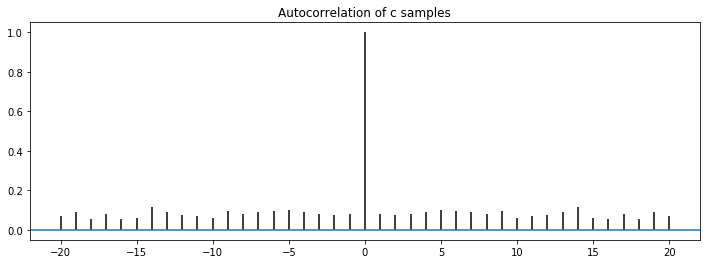

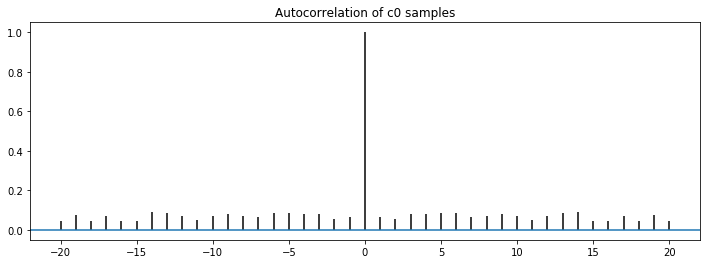

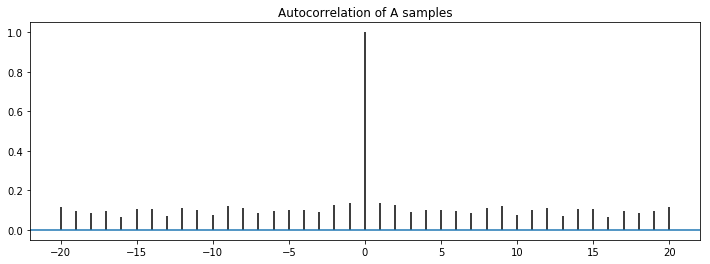

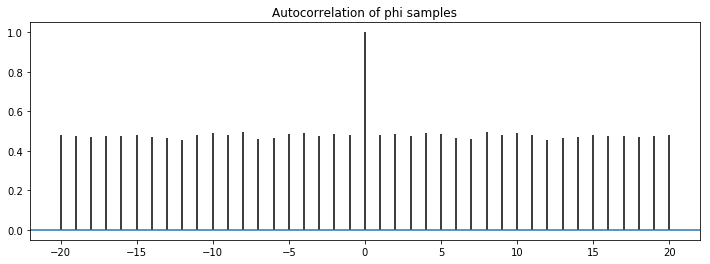

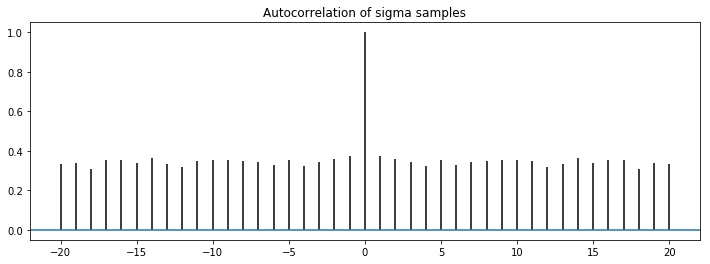

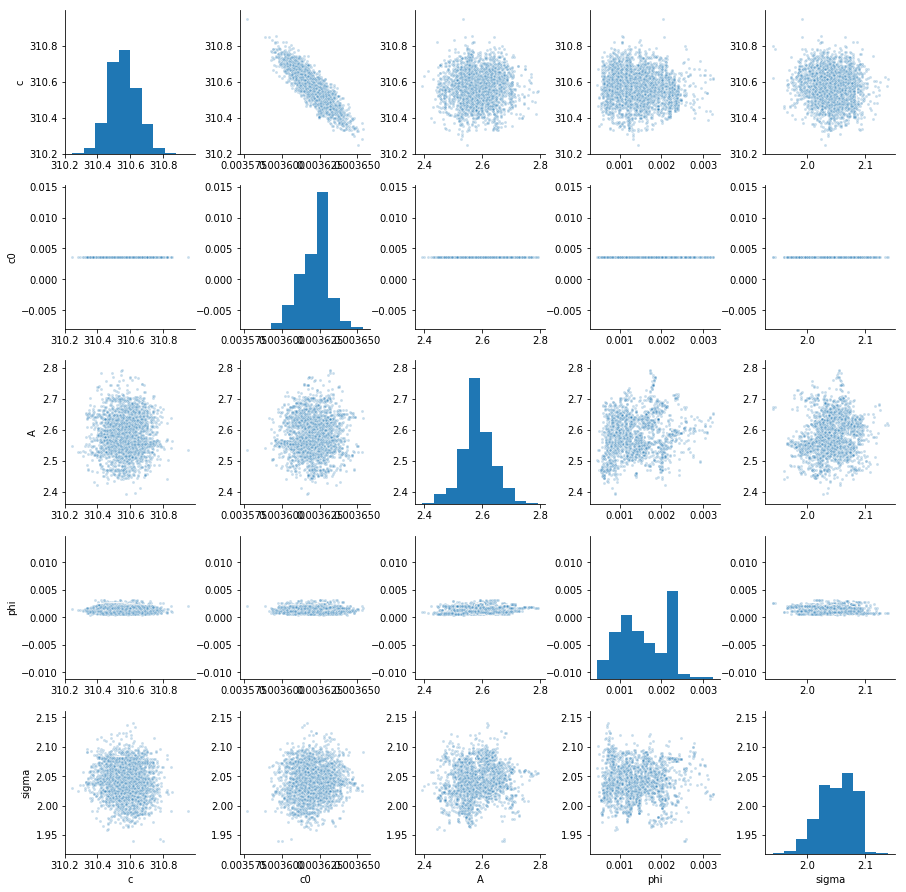

In [45]:
print('Model 1')
plot_acf(parameters_mod1, samples1)
pairplot(parameters_mod1, samples1)

Model 2


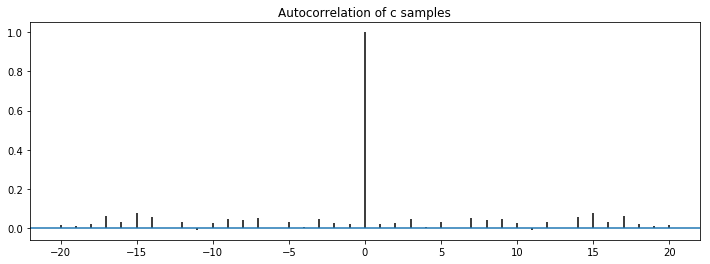

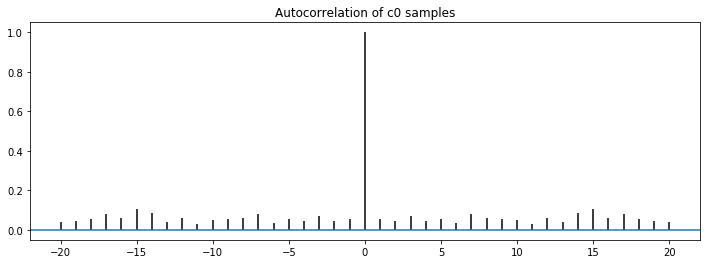

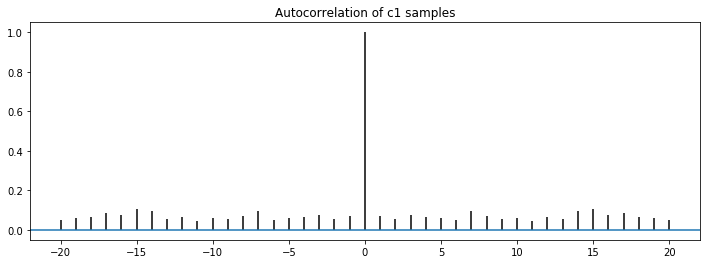

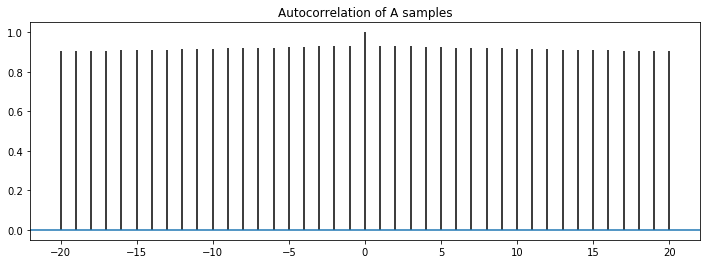

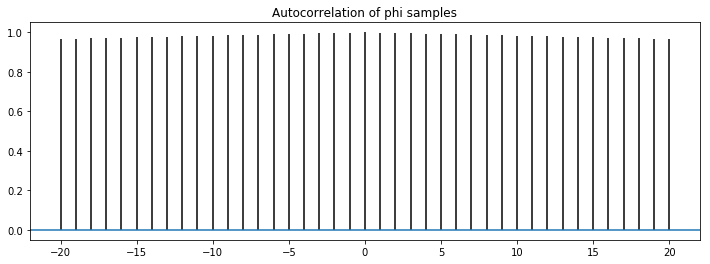

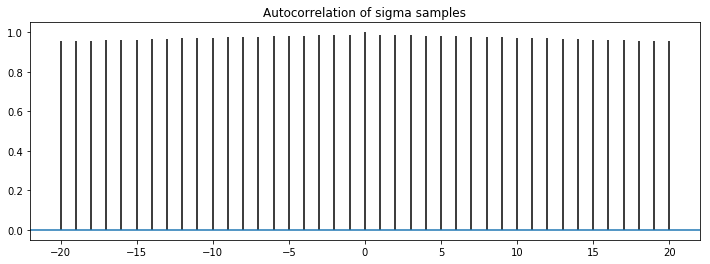

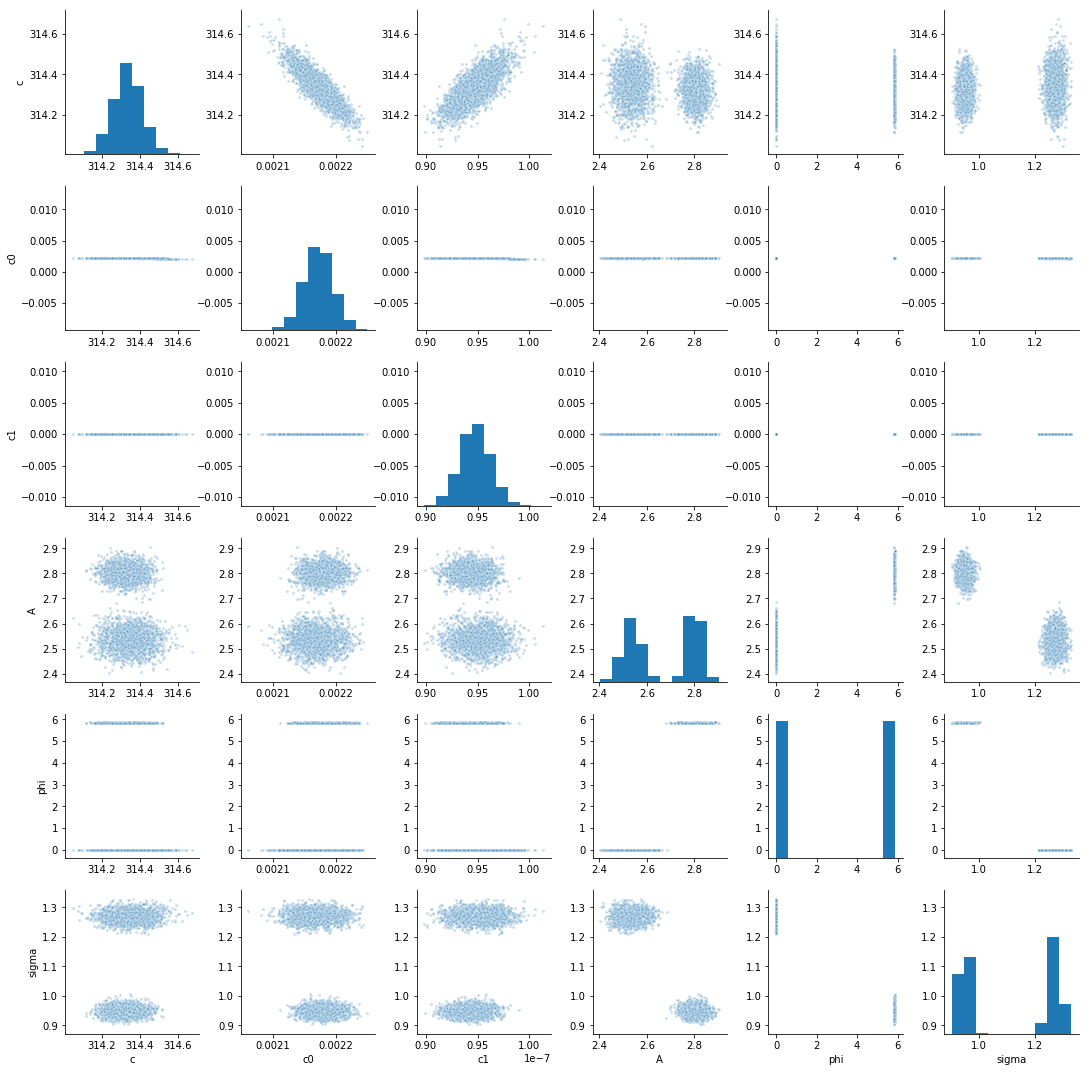

In [44]:
print('Model 2')
plot_acf(parameters, samples2)
pairplot(parameters, samples2)


Model 3


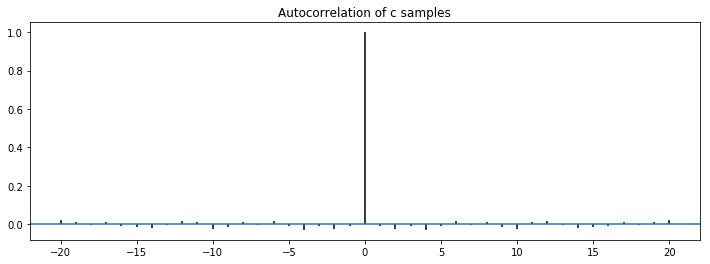

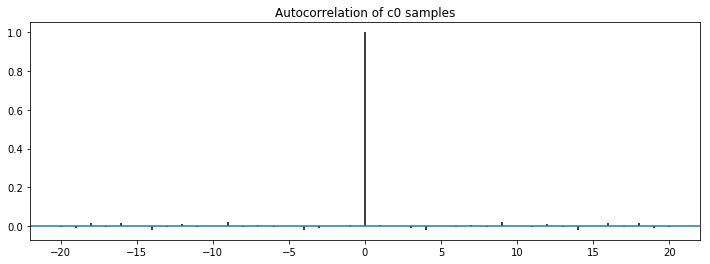

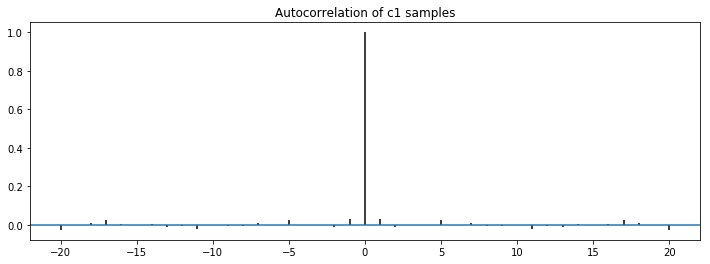

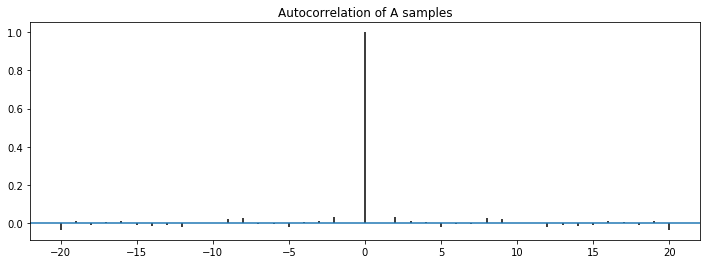

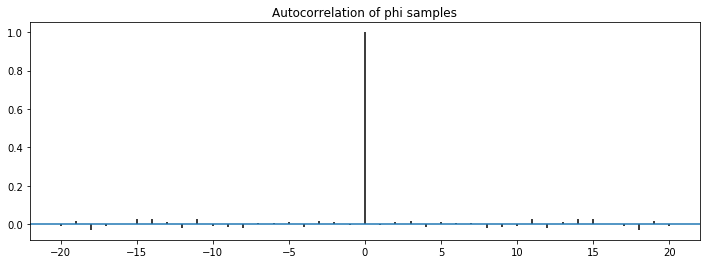

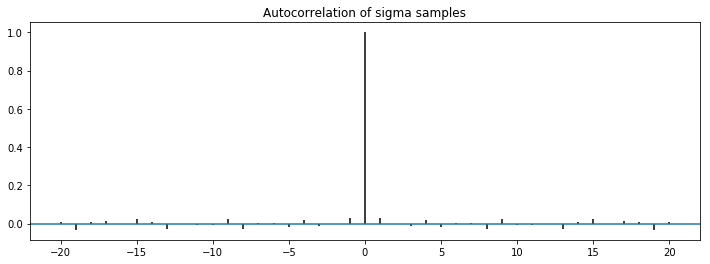

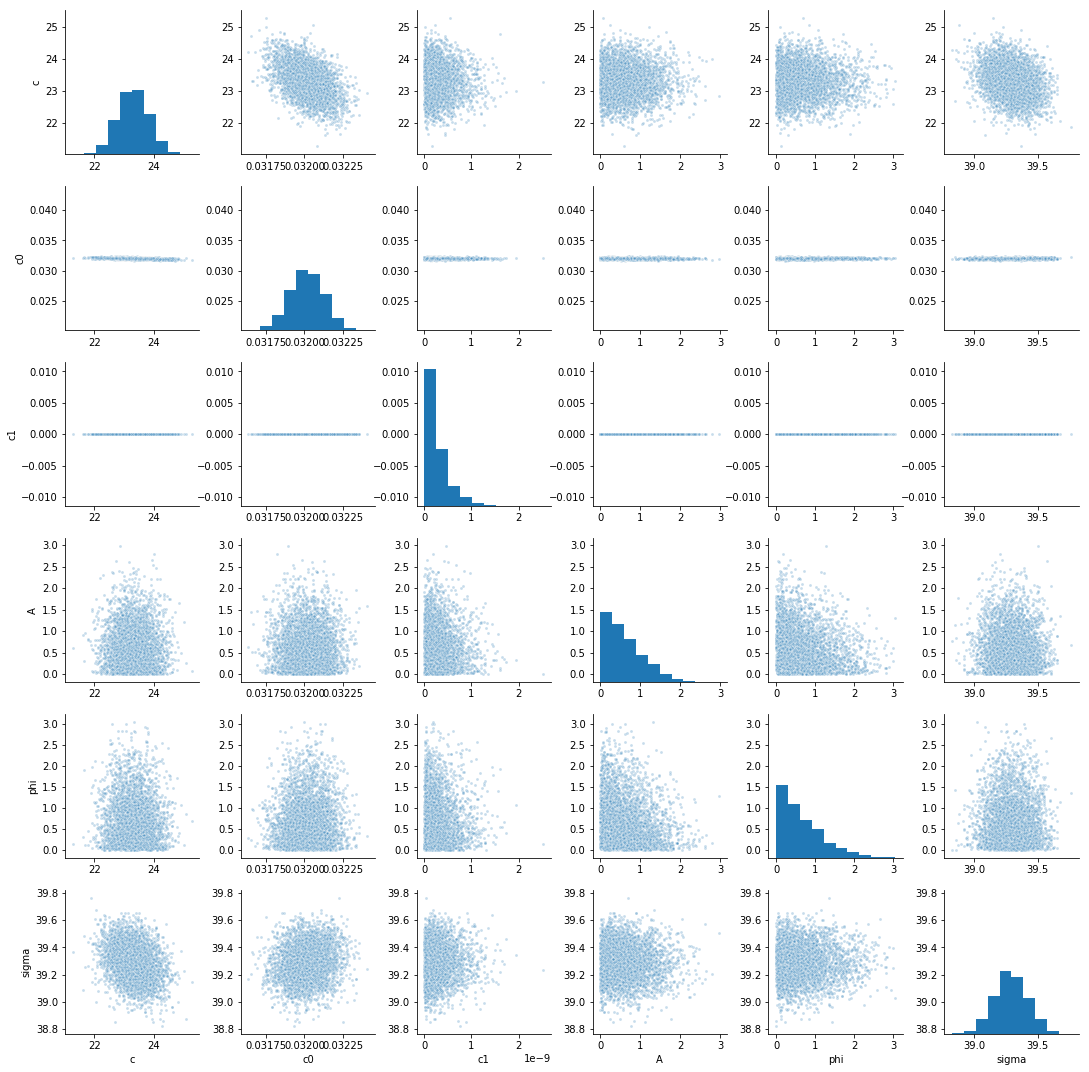

In [46]:
print('Model 3')
plot_acf(parameters, samples3)
pairplot(parameters, samples3)


Model 4


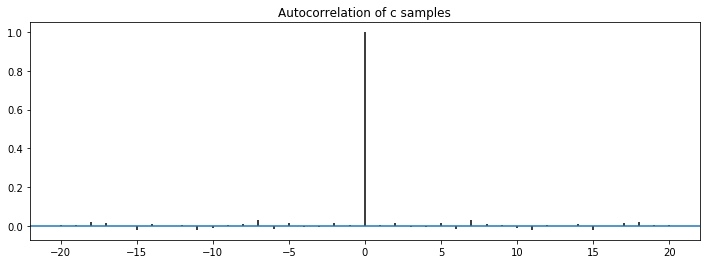

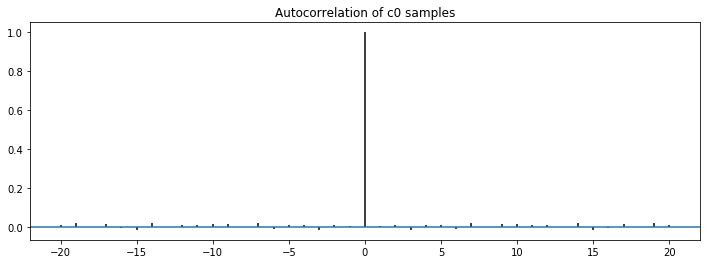

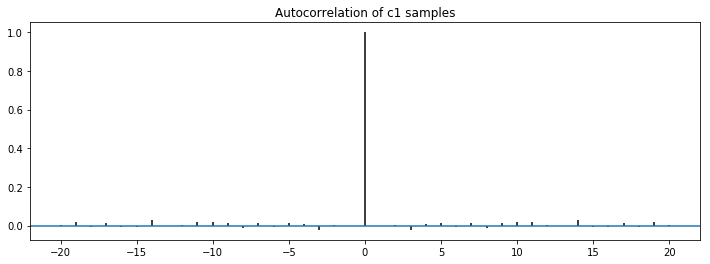

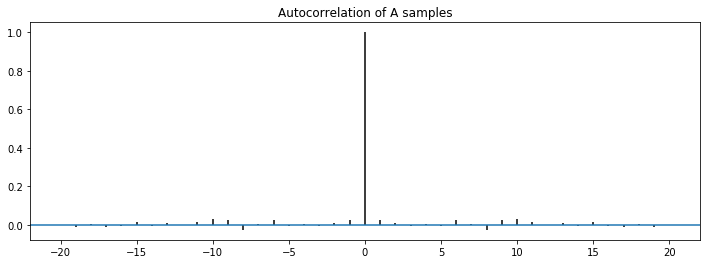

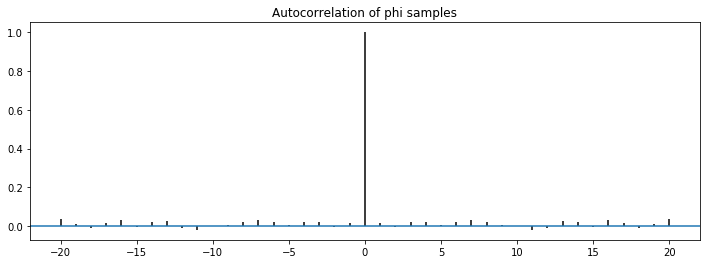

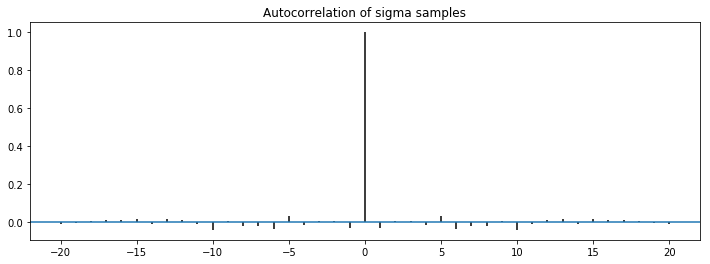

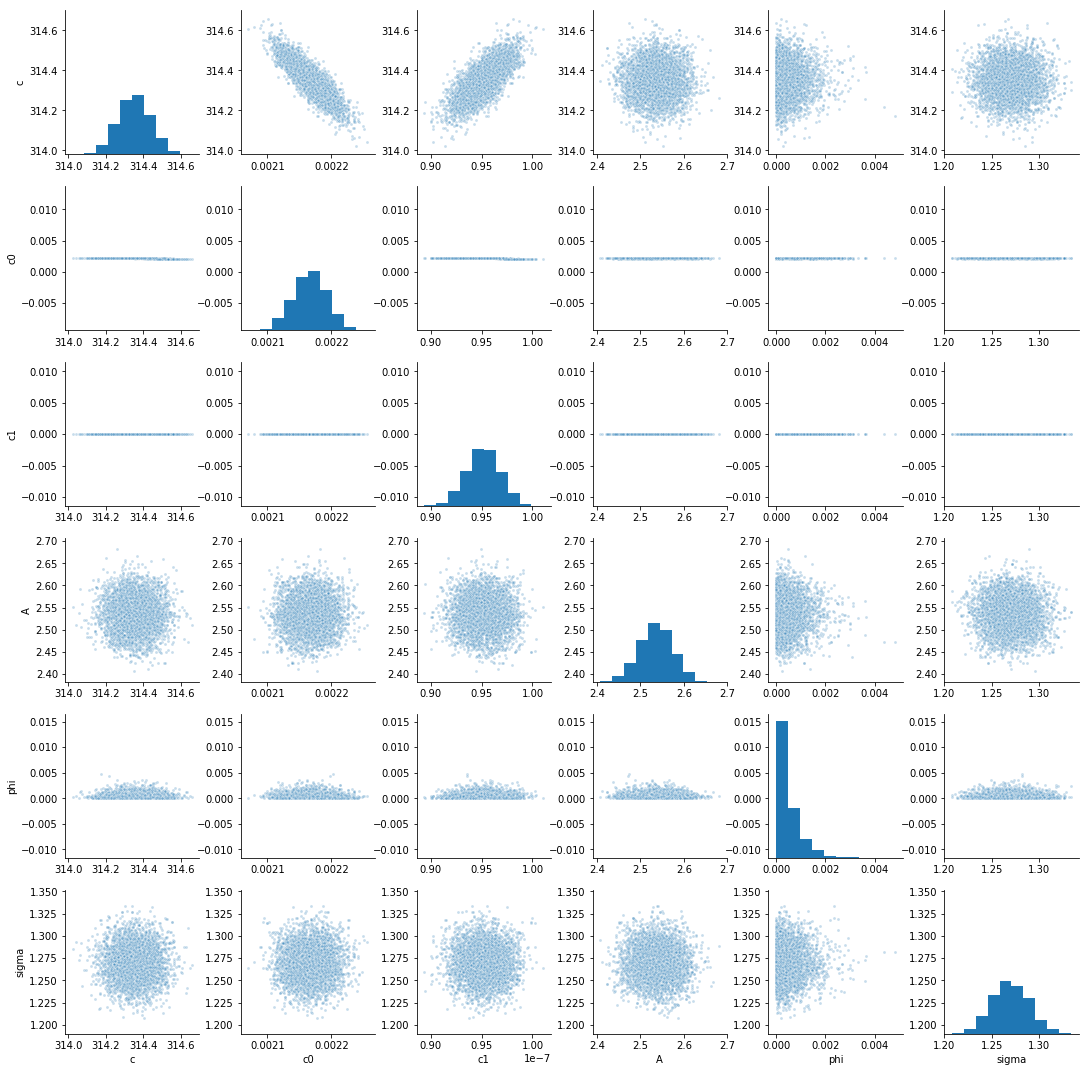

In [47]:
print('Model 4')
plot_acf(parameters, samples4)
pairplot(parameters, samples4)

## 2. Model Accuracy

In [19]:
def predict_accuracy(samples):
    # Plot the quadratic trend
    plt.figure(figsize=(8, 6))
    plt.plot(total_time_date, np.percentile(samples['trend'], 50, axis=0), color='red')
    plt.title('CO2 trend over the years')
    plt.xlabel('Year')
    plt.ylabel('CO2 level (ppm)')

    # Plot 95% confidence interval for replicated data against observed data
    plt.figure(figsize=(8, 6))
    plt.title('Observed and replicated CO2 level')
    plt.xlabel('Time')
    plt.ylabel('CO2 level (ppm)')
    # Observed data
    plt.plot(test['Time'], test['CO2'], color='orange', label='observed')
    # Replicated data
    plt.plot(test.iloc[:, 0], np.percentile(samples['cd_test'], 2.5, axis=0), color='green', label='replicated')
    plt.plot(test.iloc[:, 0], np.percentile(samples['cd_test'], 97.5, axis=0), color='green')
    plt.legend()
    plt.show()

Model 1


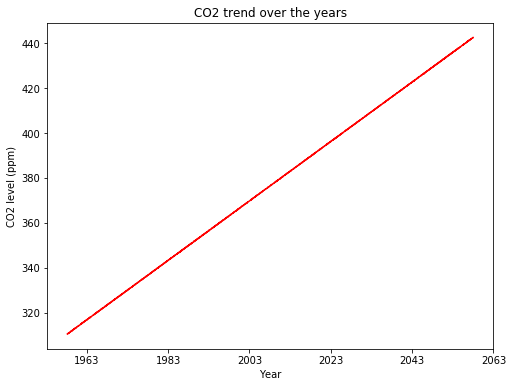

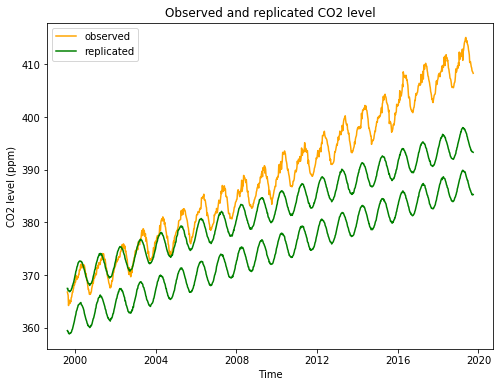

Model 2


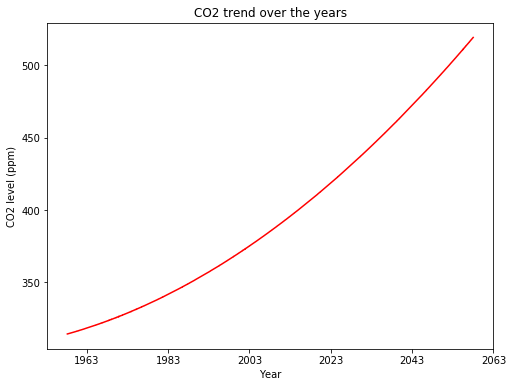

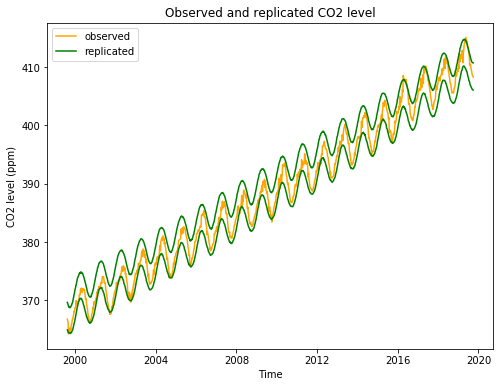

Model 3


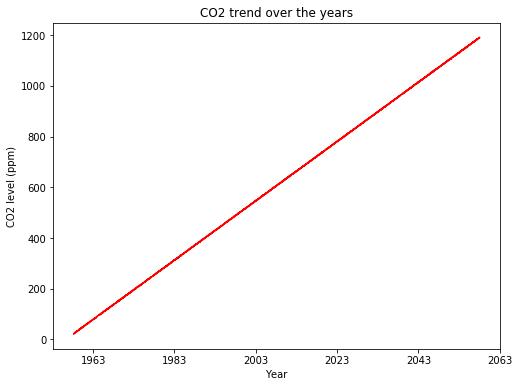

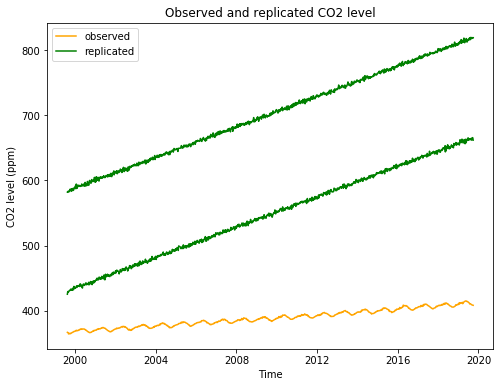

Model 4


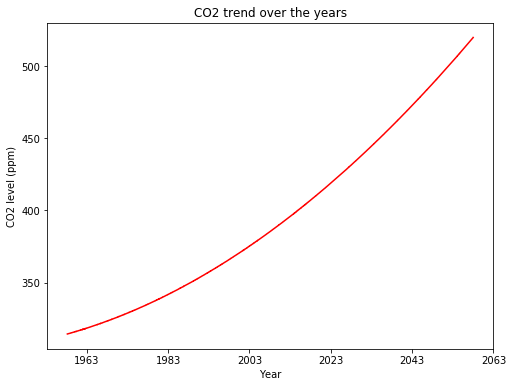

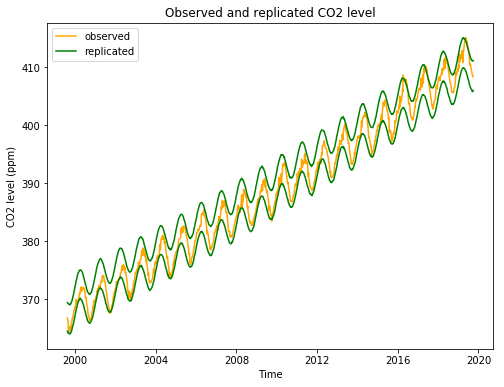

In [43]:
print('Model 1')
predict_accuracy(samples1)
print('Model 2')
predict_accuracy(samples2)
print('Model 3')
predict_accuracy(samples3)
print('Model 4')
predict_accuracy(samples4)


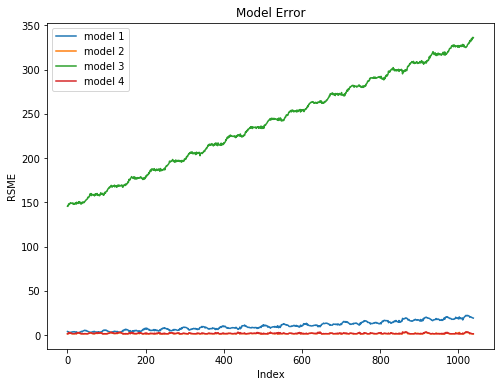

In [56]:
# Error in replication
def RSME(rep, real):
    err = []
    for i in range(len(rep)):
        err.append(np.sqrt(np.mean((rep[i]-real.iloc[i, 1])**2)))
    return err

plt.figure(figsize=(8, 6))
plt.plot(RSME(np.transpose(samples1['cd_test']), test), label='model 1')
plt.plot(RSME(np.transpose(samples2['cd_test']), test), label='model 2')
plt.plot(RSME(np.transpose(samples3['cd_test']), test), label='model 3')
plt.plot(RSME(np.transpose(samples4['cd_test']), test), label='model 4')
plt.title('Model Error')
plt.xlabel('Index')
plt.ylabel('RSME')
plt.legend()

# III. Prediction
Model 4 was chosen to generate predictions.

In [52]:
# Predicted data for the next 40 years
future = pd.concat([future, pd.Series(np.percentile(samples4['cd_future'], 2.5, axis=0)), pd.Series(np.percentile(samples4['cd_future'], 50, axis=0)), pd.Series(np.percentile(samples4['cd_future'], 97.5, axis=0))], axis=1)
future = future.rename(columns={0: '2.5%', 1: '50%', 2: '97.5%'})
print(future.head())
print(future.tail())

        Time      t        2.5%         50%       97.5%
0 2019-10-06  22471  406.050618  408.596559  411.148661
1 2019-10-13  22478  406.072312  408.690201  411.227928
2 2019-10-20  22485  406.261699  408.825368  411.230880
3 2019-10-27  22492  406.475821  408.973243  411.658277
4 2019-11-03  22499  406.702131  409.211055  411.868138
           Time      t        2.5%         50%       97.5%
1992 2057-12-09  36415  515.161587  518.645129  522.159974
1993 2057-12-16  36422  515.355586  518.960300  522.505106
1994 2057-12-23  36429  515.624004  519.337323  522.990192
1995 2057-12-30  36436  516.007535  519.718957  523.371680
1996 2058-01-06  36443  516.301202  520.110811  523.618031


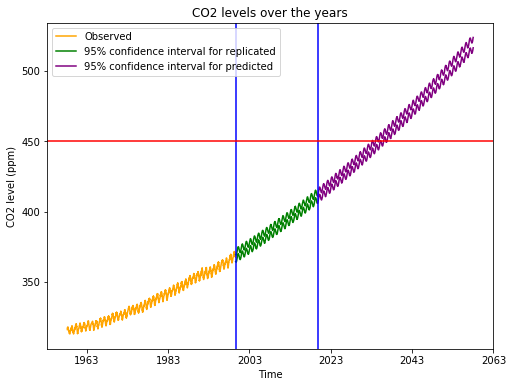

In [40]:
# Plot observed, replicated and predicted data
plt.figure(figsize=(8, 6))
# Observed
plt.plot(train['Time'], train['CO2'], label='Observed', color='orange')
# Replicated
plt.plot(test.iloc[:, 0], np.percentile(samples4['cd_test'], 2.5, axis=0), label='95% confidence interval for replicated', color='green')
plt.plot(test.iloc[:, 0], np.percentile(samples4['cd_test'], 97.5, axis=0), color='green')
# Predicted
plt.plot(future['Time'], np.percentile(samples4['cd_future'], 2.5, axis=0), label='95% confidence interval for predicted', color='purple')
plt.plot(future['Time'], np.percentile(samples4['cd_future'], 97.5, axis=0), color='purple')
plt.axvline(test.iloc[0, 0], color='blue')
plt.axvline(future.iloc[0, 0], color='blue')
plt.axhline(450, color='red')
plt.title('CO2 levels over the years')
plt.xlabel('Time')
plt.ylabel('CO2 level (ppm)')
plt.legend()

In [42]:
# When will the apocalypse be?
ind = np.where((np.abs(future.loc[:, '50%'] - 450) <= 0.05))[0][0]
future.iloc[ind-3:ind+7, :]

,Time,t,2.5%,50%,97.5%
749,2034-02-12,27714,446.431932,449.304473,452.152199
750,2034-02-19,27721,446.572689,449.544792,452.273668
751,2034-02-26,27728,446.821899,449.720788,452.544951
752,2034-03-05,27735,447.203147,449.960553,452.757756
753,2034-03-12,27742,447.250089,450.081540,452.870199
754,2034-03-19,27749,447.397352,450.203000,452.958130
755,2034-03-26,27756,447.520084,450.325974,453.150093
756,2034-04-02,27763,447.582369,450.316130,453.078404
757,2034-04-09,27770,447.506649,450.353947,453.184948
758,2034-04-16,27777,447.604363,450.335958,453.143422


In [55]:
ind2 = np.where((np.abs(future.loc[:, '2.5%'] - 450) <= 0.1))[0][0]
future.iloc[ind2-3:ind2+7, :]

,Time,t,2.5%,50%,97.5%
802,2035-02-18,28085,449.362167,452.221061,454.999059
803,2035-02-25,28092,449.530847,452.449082,455.282692
804,2035-03-04,28099,449.802648,452.637642,455.511654
805,2035-03-11,28106,449.926910,452.787015,455.623615
806,2035-03-18,28113,450.142758,452.949979,455.853080
807,2035-03-25,28120,450.228778,452.964924,455.882407
808,2035-04-01,28127,450.187944,453.092061,455.941712
809,2035-04-08,28134,450.275390,453.123132,455.878199
810,2035-04-15,28141,450.210750,453.098330,455.802632
811,2035-04-22,28148,450.191453,453.075421,455.771362
